In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NPY after 1971

In [2]:
cp = pd.read_csv("data/COMPUSTAT.csv")

In [3]:
cp = cp[(cp["dvc"] >= 0) & (cp["prstkc"] >= 0) & (cp["pstkrv"] >= 0) & (cp["sstk"] >= 0)].dropna()
cp["np_new"] = cp["dvc"] + cp["prstkc"] - cp["sstk"]

# CRSP: mkt cap, volatility, momentum

In [4]:
crsp = pd.read_csv("data/CRSP/Monthly.csv")
crsp["PRC"] = np.abs(crsp["PRC"])
crsp["RET"] = pd.to_numeric(crsp["RET"], errors='coerce')
crsp["RET"] = crsp["RET"].clip(-1, 5)
crsp["RETX"] = pd.to_numeric(crsp["RETX"], errors='coerce')
crsp["RETX"] = crsp["RETX"].clip(-1, 5)

In [5]:
crsp["dividend_yield"] = crsp["RET"] - crsp["RETX"]

## Market cap

In [6]:
crsp["cap"] = crsp["PRC"] * crsp["SHROUT"]
crsp["prev_cap"] = crsp.groupby("PERMNO")["cap"].shift(1)

year_end_cap = crsp[crsp["date"] % 10000 // 100 == 12].copy()
year_end_cap["fyear"] = year_end_cap["date"] // 10000
year_end_cap.rename(columns={"cap": "year_end_cap"}, inplace=True)
year_end_cap = year_end_cap[["PERMNO", "fyear", "year_end_cap"]]

## Net issuance

In [7]:
crsp["adj_shrout"] = crsp["SHROUT"] * crsp["CFACSHR"]
crsp["adj_prc"] = crsp["PRC"] / crsp["CFACPR"]

crsp["dshrout"] = crsp.groupby("PERMNO")["adj_shrout"].diff()
crsp["prev_adj_prc"] = crsp.groupby("PERMNO")["adj_prc"].shift(1)
crsp["prev_prc"] = crsp.groupby("PERMNO")["PRC"].shift(1)

crsp["ni_old"] = crsp["dshrout"] * (crsp["prev_prc"] + crsp["PRC"]) / 2 
crsp["ni_old_adj"] = crsp["dshrout"] * (crsp["prev_adj_prc"] + crsp["adj_prc"]) / 2

In [8]:
crsp["fyear"] = crsp["date"] // 10000 

In [9]:
yearly_net_issuance = crsp.groupby(["PERMNO", "fyear"], as_index=False)[["ni_old", "ni_old_adj", "dividend_yield"]].sum()

In [10]:
yearly_net_issuance = pd.merge(yearly_net_issuance, year_end_cap)

In [11]:
cp = pd.merge(cp, yearly_net_issuance, left_on=["LPERMNO", "fyear"], right_on=["PERMNO", "fyear"], how="outer")

In [12]:
cp["npy_old"] = cp["dividend_yield"] - cp["ni_old"] / cp["year_end_cap"]
cp["npy_old_adj"] = cp["dividend_yield"] - cp["ni_old_adj"] / cp["year_end_cap"]
cp["npy_new"] = cp["np_new"] / cp["year_end_cap"]

In [13]:
cp["npy"] = cp["npy_new"].copy()
cp.loc[pd.isna(cp["npy"]), "npy"] = cp.loc[pd.isna(cp["npy"]), "npy_old"]
cp["npy_adj"] = cp["npy_new"].copy()
cp.loc[pd.isna(cp["npy_adj"]), "npy_adj"] = cp.loc[pd.isna(cp["npy_adj"]), "npy_old_adj"]

## 36 month vol

In [14]:
ret_mat = crsp[["PERMNO", "date", "RET"]].drop_duplicates() \
                                         .set_index(["date", "PERMNO"]) \
                                         .sort_index() \
                                         .unstack() 

vol = ret_mat.rolling(36).std().shift(1)
ct = ret_mat.rolling(36).count().shift(1)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\window\rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(


## Momentum

In [15]:
momentum = (np.exp(np.log(ret_mat+1).rolling(11).sum()) - 1).shift(2)

## Merge

In [16]:
vol = vol.stack()
ct = ct.stack()
momentum = momentum.stack()

In [17]:
vol = vol.reset_index().rename(columns={"RET": "volatility"})
ct =  ct.reset_index().rename(columns={"RET": "count"})
momentum = momentum.reset_index().rename(columns={"RET": "momentum"})

In [18]:
merged = pd.merge(vol, ct)
merged = pd.merge(merged, momentum)

# Return: rebalancing in Jan, Apr, Jul, Oct.

In [19]:
qret = ret_mat.rolling(3).sum().shift(-2)
qret = qret.stack().reset_index()

In [20]:
merged = pd.merge(merged, qret)
merged = pd.merge(merged, crsp[["date", "PERMNO", "prev_cap"]])
merged["year_month"] = merged["date"] // 100

In [21]:
quarterly_data = merged[(merged["year_month"] % 100).isin([1, 4, 7, 10])]

In [22]:
quarterly_data = quarterly_data[quarterly_data["count"] == 36]

## Merge NPY

In [23]:
quarterly_data = merged[(merged["year_month"] % 100).isin([1, 4, 7, 10])]
quarterly_data = quarterly_data[quarterly_data["count"] == 36]
quarterly_data["fyear"] = quarterly_data["year_month"] // 100 - 1
quarterly_data.loc[quarterly_data["year_month"]%100 <= 6, "fyear"] = quarterly_data.loc[quarterly_data["year_month"]%100 <= 6, "fyear"] - 1

In [24]:
quarterly_data

,date,PERMNO,volatility,count,momentum,RET,prev_cap,year_month,fyear
0,19290131,10022,0.080366,36.0,0.311483,-0.019703,1.414400e+04,192901,1927
1,19290131,10030,0.076493,36.0,0.069718,0.161904,3.115200e+04,192901,1927
2,19290131,10049,0.113707,36.0,-0.248020,0.019589,4.050800e+04,192901,1927
3,19290131,10057,0.197684,36.0,3.051279,0.120026,1.537500e+04,192901,1927
4,19290131,10065,0.108887,36.0,1.139754,0.503266,4.620000e+04,192901,1927
...,...,...,...,...,...,...,...,...,...
3378554,20220131,93426,0.096287,36.0,0.090535,-0.132921,4.678234e+05,202201,2020
3378555,20220131,93427,0.099093,36.0,0.424927,-0.110033,4.385522e+06,202201,2020
3378556,20220131,93429,0.069981,36.0,0.406317,-0.121909,1.390625e+07,202201,2020
3378557,20220131,93434,0.179275,36.0,-0.003413,-0.232717,1.061697e+05,202201,2020


In [25]:
quarterly_data = pd.merge(quarterly_data, cp[["PERMNO", "fyear", "npy", "npy_adj"]], 
                 left_on=["fyear", "PERMNO"], right_on=["fyear", "PERMNO"])
quarterly_data["date"] = pd.to_datetime(quarterly_data["date"].astype(str))

# Use npy data

## Choose stock with np

In [26]:
def conservative(raw_df, var):
    # print(raw_df["date"].iloc[0])
    df = raw_df.copy()
    df["cap_rank"] = (-df["prev_cap"]).rank()
    df = df[df["cap_rank"] <= 1000]

    df["vol_rank"] = df["volatility"].rank()
    df = df[df["vol_rank"] <= 500].copy()

    df["npy_rank"] = df[var].rank()
    df["momentum_rank"] = df["momentum"].rank()

    df["tot_rank"] = df["npy_rank"] + df["momentum_rank"]
    final = df[(-df["tot_rank"]).rank() <= 100]
    
    return final["RET"].mean()

In [27]:
conservative_ret = quarterly_data.groupby("date").apply(conservative, var="npy")

In [28]:
def speculative(raw_df, var):
    # print(raw_df["date"].iloc[0])
    df = raw_df.copy()
    df["cap_rank"] = (-df["prev_cap"]).rank()
    df = df[df["cap_rank"] <= 1000]

    df["vol_rank"] = (-df["volatility"]).rank()
    df = df[df["vol_rank"] <= 500].copy()

    df["npy_rank"] = df[var].rank()
    df["momentum_rank"] = df["momentum"].rank()

    df["tot_rank"] = df["npy_rank"] + df["momentum_rank"]
    final = df[df["tot_rank"].rank() <= 100]
    #display(final)
    return final["RET"].mean()

In [29]:
speculative_ret = quarterly_data.groupby("date").apply(speculative, var="npy_adj")

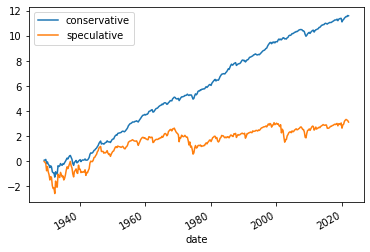

In [30]:
np.log((conservative_ret+1).cumprod()).plot()
np.log((speculative_ret+1).cumprod()).plot()
plt.legend(["conservative", "speculative"])

In [31]:
compare = pd.concat([speculative_ret, conservative_ret], axis=1)
compare = compare[compare.index <= "2016-12-31"]
compare.columns = ["speculative", "conservative"]
compare["decade"] = (compare.index.year) // 10 * 10
((compare+1).groupby("decade").prod() ** (0.1)) - 1

,speculative,conservative
decade,,
1921,-0.074400,-0.018011
1931,0.014123,0.024895
1941,0.140676,0.179482
1951,0.125681,0.223130
1961,0.034370,0.132448
1971,-0.050178,0.120778
1981,0.050988,0.216381
1991,0.081631,0.156499
2001,-0.048602,0.073146


In [32]:
compare[compare.index <= "1939-12-31"]

,speculative,conservative,decade
date,,,
1929-01-31,-0.036972,0.069580,1920
1929-04-30,-0.052537,0.026550,1920
1929-07-31,-0.105850,0.043663,1920
1929-10-31,-0.434256,-0.272368,1920
1930-01-31,0.407106,0.126980,1930
1930-04-30,-0.346917,-0.173312,1930
1930-07-31,-0.202861,-0.070609,1930
1930-10-31,-0.344394,-0.172474,1930
1931-01-31,0.310094,0.154424,1930


### Analysis of conservative strategy

In [47]:
sharpe=compare.groupby('decade')['conservative'].apply(lambda x: x.mean()/x.std()*2)

Text(0.5, 1.0, 'Sharpe ratio')

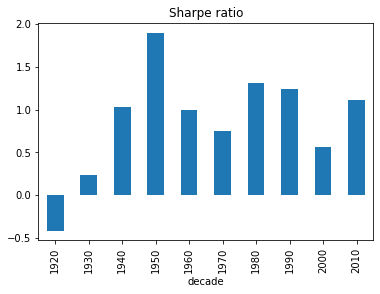

In [53]:
ax=sharpe.plot.bar()
ax.set_title('Sharpe ratio')

In [59]:
x=compare['conservative']
print('1921 to 2021 Sharpe:',x.mean()/x.std()*2)

1921 to 2021 Sharpe: 0.7286827971149145


In [58]:
x

date
1929-01-31    0.069580
1929-04-30    0.026550
1929-07-31    0.043663
1929-10-31   -0.272368
1930-01-31    0.126980
                ...   
2015-10-30    0.060565
2016-01-29    0.028401
2016-04-29    0.045146
2016-07-29   -0.006629
2016-10-31    0.008655
Name: conservative, Length: 352, dtype: float64

###  Plot different portfolio Sharpe ratios

In [186]:
compare['year']=compare.index
compare['year']=compare['year'].apply(lambda x: str(x.year))

In [187]:
year_ret=compare.groupby('year')['conservative'].apply(lambda x: (1+x).prod()-1)

In [188]:
### SIZE/BM
size_bm=pd.read_csv("6_Portfolios_2x3_CSV/size_bm_without_div.csv",index_col=0)
size_bm=size_bm[(size_bm.index<=2016)&(size_bm.index>=1929)]
size_bm_sharpe=size_bm.apply(lambda x:x.mean()/x.std())
index=['Formula','SG','SN','SV','BG','BN','BV']
heights=[year_ret.mean()/year_ret.std()]+size_bm_sharpe.values.tolist()

Text(0, 0.5, 'Sharpe with annual return')

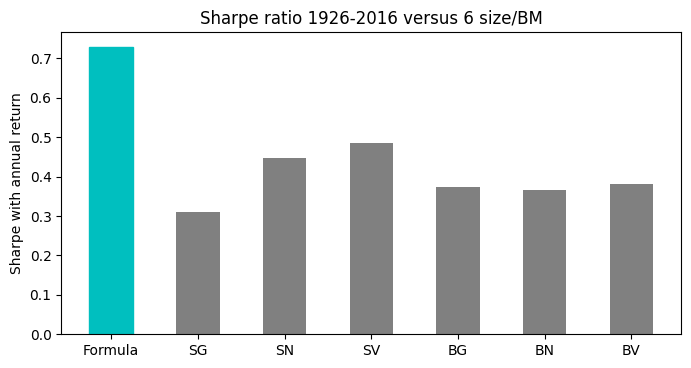

In [189]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=100)
bar_list=plt.bar(index,heights,color=['grey'],width=0.5)
bar_list[0].set_color('c')
plt.title('Sharpe ratio 1926-2016 versus 6 size/BM')
plt.ylabel('Sharpe with annual return')

In [190]:
### SIZE/Mom
size_mom=pd.read_excel("6_Portfolios_ME_Prior_12_2_CSV/Size_Mom.xlsx",index_col=0)
size_mom=size_mom[(size_mom.index<=2016)&(size_mom.index>=1929)]
size_mom_sharpe=size_mom.apply(lambda x:x.mean()/x.std())
index=['Formula','SL','SM','SH','BL','BM','BH']
heights=[year_ret.mean()/year_ret.std()]+size_mom_sharpe.values.tolist()

Text(0, 0.5, 'Sharpe with annual return')

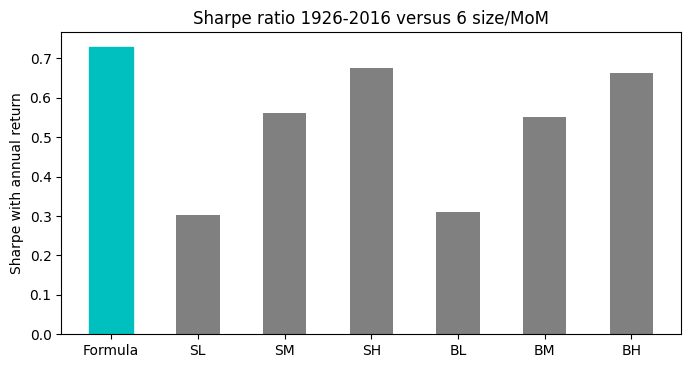

In [191]:
figure(figsize=(8, 4), dpi=100)
bar_list=plt.bar(index,heights,color=['grey'],width=0.5)
bar_list[0].set_color('c')
plt.title('Sharpe ratio 1926-2016 versus 6 size/MoM')
plt.ylabel('Sharpe with annual return')

In [192]:
year_ret

year
1929   -0.166192
1930   -0.283464
1931   -0.337721
1932   -0.090495
1933    0.899255
          ...   
2012    0.168854
2013    0.314676
2014    0.143565
2015    0.021567
2016    0.076945
Name: conservative, Length: 88, dtype: float64

In [193]:
### Size, BM, Profitability
year_ret_63=year_ret[(year_ret.index>='1963')]
size_bm_profit=pd.read_excel("32_Portfolios_ME_BEME_OP_2x4x4_Wout_Div_CSV/SizeBMOP_without_Div.xlsx",index_col=0)
size_bm_profit=size_bm_profit[(size_bm_profit.index<=2016)&(size_bm_profit.index>=1963)]
size_bm_profit_sharpe=size_bm_profit.apply(lambda x:x.mean()/x.std())
index=['Formula']+size_bm_profit_sharpe.index.to_list()
heights=[year_ret_63.mean()/year_ret_63.std()]+size_bm_profit_sharpe.values.tolist()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

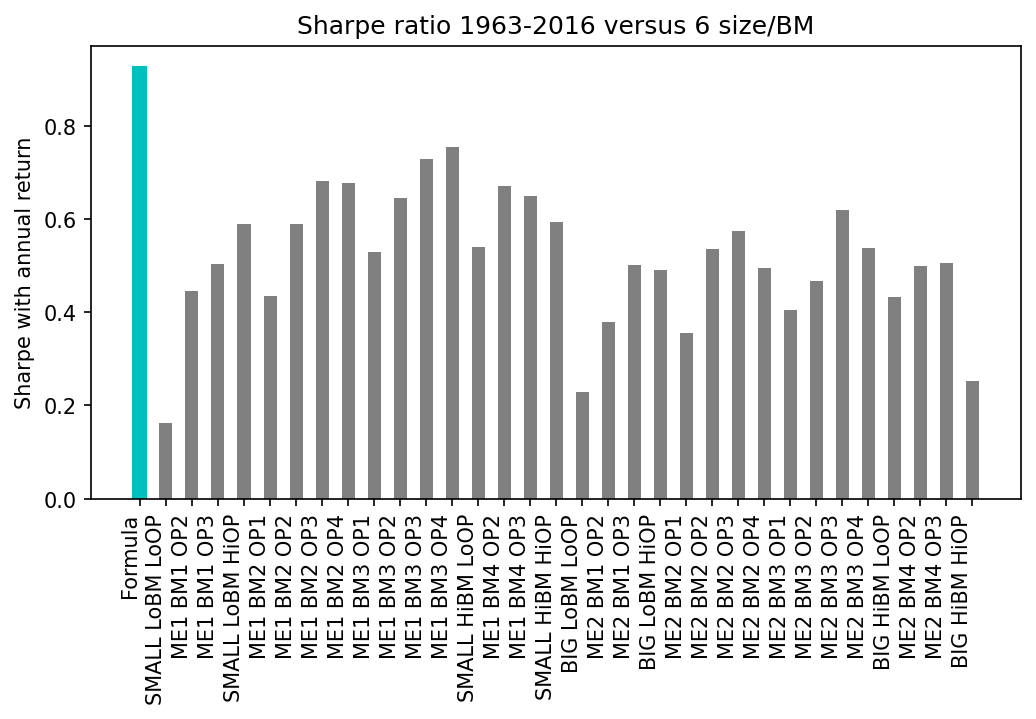

In [194]:
figure(figsize=(8, 4), dpi=150)
bar_list=plt.bar(index,heights,color=['grey'],width=0.5)
bar_list[0].set_color('c')
plt.title('Sharpe ratio 1963-2016 versus 6 size/BM')
plt.ylabel('Sharpe with annual return')
plt.xticks(rotation=90, ha='right')

In [195]:
### Size, BM, Investment
year_ret_63=year_ret[(year_ret.index>='1963')]
size_bm_inv=pd.read_excel("32_Portfolios_ME_BEME_INV_2x4x4_Wout_Div_CSV/Size_BM_INV_without_Div.xlsx",index_col=0)
size_bm_inv=size_bm_inv[(size_bm_inv.index<=2016)&(size_bm_inv.index>=1963)]
size_bm_inv_sharpe=size_bm_inv.apply(lambda x:x.mean()/x.std())
index=['Formula']+size_bm_inv_sharpe.index.to_list()
heights=[year_ret_63.mean()/year_ret_63.std()]+size_bm_profit_sharpe.values.tolist()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

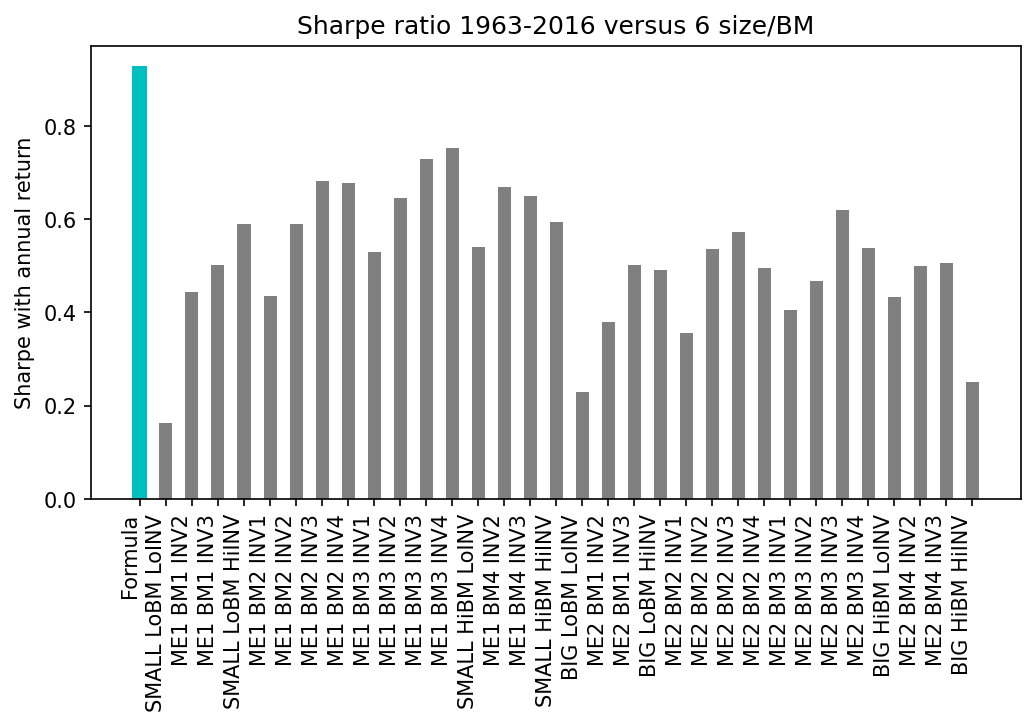

In [196]:
figure(figsize=(8, 4), dpi=150)
bar_list=plt.bar(index,heights,color=['grey'],width=0.5)
bar_list[0].set_color('c')
plt.title('Sharpe ratio 1963-2016 versus 6 size/BM')
plt.ylabel('Sharpe with annual return')
plt.xticks(rotation=90, ha='right')